In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/lib/kaggle/gcp.py
/kaggle/input/general-language-understanding-evaluation/STS/STS-B/test.tsv
/kaggle/input/general-language-understanding-evaluation/STS/STS-B/dev.tsv
/kaggle/input/general-language-understanding-evaluation/STS/STS-B/train.tsv
/kaggle/input/general-language-understanding-evaluation/STS/STS-B/readme.txt
/kaggle/input/general-language-understanding-evaluation/STS/STS-B/LICENSE.txt
/kaggle/input/general-language-understanding-evaluation/STS/STS-B/original/sts-train.tsv
/kaggle/input/general-language-understanding-evaluation/STS/STS-B/original/sts-dev.tsv
/kaggle/input/general-language-understanding-evaluation/STS/STS-B/original/sts-test.tsv
/kaggle/input/general-language-understanding-evaluation/QNLI/QNLI/test.tsv
/kaggle/input/general-language-understanding-evaluation/QNLI/QNLI/dev.tsv
/kaggle/input/general-language-understanding-evaluation/QNLI/QNLI/train.tsv
/kaggle/input/general-language-understanding-evaluation/RTE/RTE/test.tsv
/kaggle/input/general-language-u

# **Fine-Tune XLNET-BASE on STS-B:**

In [7]:
#referencing this tutorial: https://www.kaggle.com/jaskaransingh/xlnet-fine-tuning-with-pytorch
#install huggingface transformers package
!pip install transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [8]:
#lets load the data into a dataframe
import pandas as pd

train_df = pd.read_csv('../input/general-language-understanding-evaluation/STS/STS-B/train.tsv', sep='\t', error_bad_lines=False)
train_df = train_df.dropna()
dev_df = pd.read_csv('../input/general-language-understanding-evaluation/STS/STS-B/dev.tsv', sep='\t', error_bad_lines=False)
dev_df = dev_df.dropna()

b'Skipping line 2509: expected 10 fields, saw 11\nSkipping line 2650: expected 10 fields, saw 11\nSkipping line 2727: expected 10 fields, saw 11\nSkipping line 3071: expected 10 fields, saw 11\nSkipping line 3393: expected 10 fields, saw 11\n'
b'Skipping line 1042: expected 10 fields, saw 11\nSkipping line 1066: expected 10 fields, saw 11\nSkipping line 1083: expected 10 fields, saw 11\nSkipping line 1137: expected 10 fields, saw 11\nSkipping line 1150: expected 10 fields, saw 11\n'


In [9]:
train_df.head()

,index,genre,filename,year,old_index,source1,source2,sentence1,sentence2,score
0,0,main-captions,MSRvid,2012test,1,none,none,A plane is taking off.,An air plane is taking off.,5.00
1,1,main-captions,MSRvid,2012test,4,none,none,A man is playing a large flute.,A man is playing a flute.,3.80
2,2,main-captions,MSRvid,2012test,5,none,none,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,3,main-captions,MSRvid,2012test,6,none,none,Three men are playing chess.,Two men are playing chess.,2.60
4,4,main-captions,MSRvid,2012test,9,none,none,A man is playing the cello.,A man seated is playing the cello.,4.25


In [10]:
#xlnet takes fixed size inputs so lets find the max sentence length
print(train_df['sentence1'].map(lambda x: len(x)).max())
print(dev_df['sentence1'].map(lambda x: len(x)).max())

400
460


(array([280., 387., 271., 183., 141.,  98.,  52.,  27.,  12.,  12.]),
 array([ 17. ,  33.9,  50.8,  67.7,  84.6, 101.5, 118.4, 135.3, 152.2,
        169.1, 186. ]),
 <a list of 10 Patch objects>)

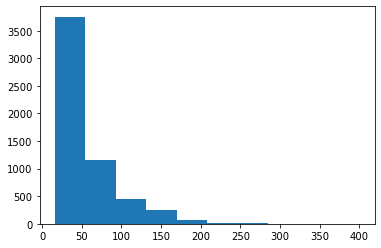

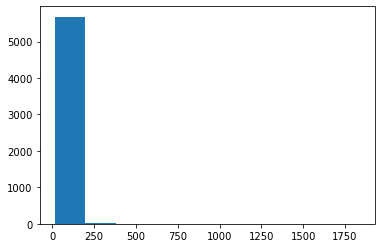

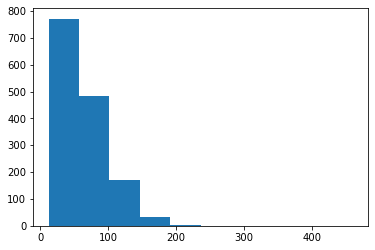

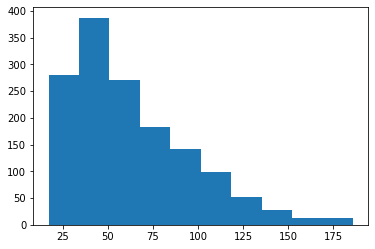

In [11]:
#lets find the distribution of sentence lengths for more intelligent selection of the max sentence length
import matplotlib.pyplot as plt

ts1 = train_df['sentence1'].map(lambda x: len(x))
ts2 = train_df['sentence2'].map(lambda x: len(x))
ds1 = dev_df['sentence1'].map(lambda x: len(x))
ds2 = dev_df['sentence2'].map(lambda x: len(x))

#based on these figures, even though the range extends up to 487, an adequate choice seems like 150
plt.figure()
plt.hist(ts1)

plt.figure()
plt.hist(ts2)

plt.figure()
plt.hist(ds1)

plt.figure()
plt.hist(ds2)


In [12]:
from transformers import AdamW, XLNetTokenizer, XLNetModel, TFXLNetModel, XLNetLMHeadModel, XLNetConfig, XLNetForSequenceClassification

#observe tokenization
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
sent = train_df['sentence1'][0]
print(sent)
print(tokenizer.tokenize(sent))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent)))

A plane is taking off.
['▁a', '▁plane', '▁is', '▁taking', '▁off', '.']
[24, 2352, 27, 637, 177, 9]


In [13]:
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset
import torch

#preprocess, return new dataset with processed columns
def preproc_sts_b_xlnet(input_df, tokenizer, max_len=150):
    #tokenize inputs using XLnet tokenizer
    #truncate to max_len - 2 to allow for sentence tokens <s>, </s>
    tokenized_sent1 = list(input_df['sentence1'].map(lambda x: tokenizer.tokenize(x)[:max_len-2]))
    tokenized_sent2 = list(input_df['sentence2'].map(lambda x: tokenizer.tokenize(x)[:max_len-2]))
    
    #convert to token IDs and add special tokens
    sent1_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_sent1]
    sent1_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in sent1_ids]
    sent2_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_sent2]
    sent2_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in sent2_ids]
    
    #pad input to max len
    sent1_ids = pad_sequences(sent1_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")
    sent2_ids = pad_sequences(sent2_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")
    
    #make torch tensor
    sent1_ids, sent2_ids = torch.from_numpy(sent1_ids), torch.from_numpy(sent2_ids)
    
    #concat into one input of shape (num_pairs, max_len*2)
    input_ids = torch.cat([sent1_ids, sent2_ids], dim=1)
    
    attention_masks = []
    seg_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
        #add segment masks for 2 sentence input, 0 indexes sentence 1, 1 indexed sentence 2
        seg_masks.append( [0]*max_len + [1]*max_len )
    
    labels = list(input_df['score'].map(lambda x: x / 5.0))
    
    #TensorDataset of form (input_ids, attention_masks, segment_masks, labels(score))
    dataset = TensorDataset( input_ids, torch.tensor(attention_masks), torch.tensor(seg_masks), torch.tensor(labels) )
    
    return dataset

#run preprocessing
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
train_dataset = preproc_sts_b_xlnet(train_df, tokenizer)
val_dataset = preproc_sts_b_xlnet(dev_df, tokenizer)

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
#create train/dev dataloaders

batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [15]:
len(train_df) - train_df.count()

index        0
genre        0
filename     0
year         0
old_index    0
source1      0
source2      0
sentence1    0
sentence2    0
score        0
dtype: int64

In [16]:
#train_df[train_df['score'].isna()]

In [17]:
class XLNet_For_Regression(torch.nn.Module):
    def __init__(self, n_linear=3):
        super(XLNet_For_Regression, self).__init__()
        #load base model
        self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
        
        #set up linear layers and regression output
        self.linear_layers = []
        for i in range(n_linear):
            self.linear_layers.append(torch.nn.Linear(768,768))
            self.linear_layers.append(torch.nn.LeakyReLU())
        self.linear_layers.append(torch.nn.Linear(768,1))
        self.linear_layers.append(torch.nn.LeakyReLU())
        
        
        self.linear_layers = torch.nn.ModuleList(self.linear_layers)
        
    def forward(self, input_ids, attention_mask, segment_mask):
        xlnet_output = self.xlnet(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=segment_mask
        )
        
        #print(xlnet_output)
        
        output = self.pool_hidden_state(xlnet_output)
        
        #print(output)
        
        for layer in self.linear_layers:
            output = layer(output)
            
        #print(output)
        
        return output
    
    #copied from: https://www.kaggle.com/jaskaransingh/xlnet-fine-tuning-with-pytorch
    def pool_hidden_state(self, last_hidden_state):
        """
        Pool the output vectors into a single mean vector 
        """
        last_hidden_state = last_hidden_state[0]
        mean_last_hidden_state = torch.mean(last_hidden_state, 1)
        return mean_last_hidden_state
        
    def freeze_xlnet_decoder(self):
        """
        Freeze XLNet weight parameters. They will not be updated during training.
        """
        for param in self.xlnet.parameters():
            param.requires_grad = False
            
    def train(self, mode=True):
        if mode:
            self.freeze_xlnet_decoder()
        super().train(mode)

In [18]:
#copied from: https://www.kaggle.com/jaskaransingh/xlnet-fine-tuning-with-pytorch
import time
import datetime
from tqdm import trange

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
    """
    Save the model to the path directory provided
    """
    model_to_save = model.module if hasattr(model, 'module') else model
    checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
    torch.save(checkpoint, save_path)
    print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
    return
  
def load_model(save_path, model_class, args=None):
    """
    Load the model from the path directory provided
    """
    checkpoint = torch.load(save_path)
    model_state_dict = checkpoint['state_dict']
    if args == None:
        model = model_class()
    else:
        model = model_class(**args)
    model.load_state_dict(model_state_dict)

    epochs = checkpoint["epochs"]
    lowest_eval_loss = checkpoint["lowest_eval_loss"]
    train_loss_hist = checkpoint["train_loss_hist"]
    valid_loss_hist = checkpoint["valid_loss_hist"]

    return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

def train(model, num_epochs,\
          optimizer,\
          criterion, \
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=None, valid_loss_set = None,\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
    """
    Train the model and save the model with the lowest validation loss
    """
    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []
    # Measure the total training time for the whole run.
    total_t0 = time.time()
    
    if train_loss_set == None:
        train_loss_set = []
    if valid_loss_set == None:
        valid_loss_set = []

    model.to(device)

    # trange is a tqdm wrapper around the normal python range
    for i in trange(num_epochs, desc="Epoch"):
        # if continue training from saved model
        actual_epoch = start_epoch + i

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set. 
        print("")
        print('======== Epoch {:} / {:} ========'.format(actual_epoch, num_epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Set our model to training mode (as opposed to evaluation mode)
        model.train()

        # Tracking variables
        tr_loss = 0
        num_train_samples = 0

        # Train the data for one epoch
        for step, batch in enumerate(train_dataloader):
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_segment_mask, b_labels = batch
            # Clear out the gradients (by default they accumulate)
            optimizer.zero_grad()
            # Forward pass
            output = model(input_ids=b_input_ids, attention_mask=b_input_mask, segment_mask=b_segment_mask)
            # store train loss
            loss = criterion(output, torch.reshape(b_labels, (b_labels.size()[0], 1)))
            tr_loss += loss.item()
            num_train_samples += b_labels.size(0)
            # Backward pass
            loss.backward()
            # Update parameters and take a step using the computed gradient
            optimizer.step()
            #scheduler.step()

        # Update tracking variables
        epoch_train_loss = tr_loss/num_train_samples
        train_loss_set.append(epoch_train_loss)

    #     print("Train loss: {}".format(epoch_train_loss))

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(epoch_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
            # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put model in evaluation mode to evaluate loss on the validation set
        model.eval()

        # Tracking variables 
        eval_loss = 0
        num_eval_samples = 0

        # Evaluate data for one epoch
        for batch in valid_dataloader:
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_segment_mask, b_labels = batch
            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate validation loss
                output = model(input_ids=b_input_ids, attention_mask=b_input_mask, segment_mask=b_segment_mask)
                # store valid loss
                loss = criterion(output, torch.reshape(b_labels, (b_labels.size()[0], 1)))
                eval_loss += loss.item()
                num_eval_samples += b_labels.size(0)

        epoch_eval_loss = eval_loss/num_eval_samples
        valid_loss_set.append(epoch_eval_loss)
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(epoch_eval_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': actual_epoch,
                'Training Loss': epoch_train_loss,
                'Valid. Loss': epoch_eval_loss,
        #             'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )


        if lowest_eval_loss == None:
            lowest_eval_loss = epoch_eval_loss
            # save model
            save_model(model, model_save_path, actual_epoch,\
                     lowest_eval_loss, train_loss_set, valid_loss_set)
        else:
            if epoch_eval_loss < lowest_eval_loss:
                lowest_eval_loss = epoch_eval_loss
                # save model
                save_model(model, model_save_path, actual_epoch,\
                           lowest_eval_loss, train_loss_set, valid_loss_set)

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return model, train_loss_set, valid_loss_set, training_stats

In [19]:
num_epochs = 10
xlbase = XLNet_For_Regression()
optimizer = AdamW(xlbase.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  # eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 weight_decay=0.01,
                 correct_bias=False
                )
criterion = torch.nn.MSELoss()

save_path = 'XLNetBase.pt'
torch.autograd.set_detect_anomaly(True) 
xlbase, tls, vls, train_stats =                         train(model=xlbase,\
                                                              num_epochs=num_epochs,\
                                                              optimizer=optimizer,\
                                                              criterion=criterion, \
                                                              train_dataloader=train_dataloader,\
                                                              valid_dataloader=validation_dataloader,\
                                                              model_save_path=save_path,\
                                                              device="cuda"
                                                              )

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


======== Epoch 0 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:16.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:02:00.

  Average training loss: 0.00
  Training epcoh took: 0:02:13

Running Validation...
  Validation Loss: 0.01
  Validation took: 0:00:33


Epoch:  10%|█         | 1/10 [02:46<25:00, 166.75s/it]

Saving model at epoch 0 with validation loss of 0.00842325081915091

======== Epoch 1 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:00:59.
  Batch   200  of    357.    Elapsed: 0:01:14.
  Batch   240  of    357.    Elapsed: 0:01:29.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:12

Running Validation...
  Validation Loss: 0.01
  Validation took: 0:00:33


Epoch:  20%|██        | 2/10 [05:33<22:12, 166.60s/it]

Saving model at epoch 1 with validation loss of 0.007279076551737153

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:00:59.
  Batch   200  of    357.    Elapsed: 0:01:14.
  Batch   240  of    357.    Elapsed: 0:01:29.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:12

Running Validation...
  Validation Loss: 0.01
  Validation took: 0:00:33


Epoch:  30%|███       | 3/10 [08:19<19:25, 166.56s/it]

Saving model at epoch 2 with validation loss of 0.005569729834326472

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:00:59.
  Batch   200  of    357.    Elapsed: 0:01:14.
  Batch   240  of    357.    Elapsed: 0:01:29.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:12

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:33


Epoch:  40%|████      | 4/10 [11:05<16:38, 166.49s/it]

Saving model at epoch 3 with validation loss of 0.004408986352878079

======== Epoch 4 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:00:59.
  Batch   200  of    357.    Elapsed: 0:01:14.
  Batch   240  of    357.    Elapsed: 0:01:29.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:12

Running Validation...


Epoch:  50%|█████     | 5/10 [13:50<13:50, 166.04s/it]

  Validation Loss: 0.01
  Validation took: 0:00:33

======== Epoch 5 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:00:59.
  Batch   200  of    357.    Elapsed: 0:01:14.
  Batch   240  of    357.    Elapsed: 0:01:29.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:12

Running Validation...


Epoch:  60%|██████    | 6/10 [16:35<11:02, 165.73s/it]

  Validation Loss: 0.00
  Validation took: 0:00:33

======== Epoch 6 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:00:59.
  Batch   200  of    357.    Elapsed: 0:01:14.
  Batch   240  of    357.    Elapsed: 0:01:29.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:12

Running Validation...


Epoch:  70%|███████   | 7/10 [19:20<08:16, 165.52s/it]

  Validation Loss: 0.01
  Validation took: 0:00:33

======== Epoch 7 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:00:59.
  Batch   200  of    357.    Elapsed: 0:01:14.
  Batch   240  of    357.    Elapsed: 0:01:29.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:12

Running Validation...


Epoch:  80%|████████  | 8/10 [22:05<05:30, 165.34s/it]

  Validation Loss: 0.00
  Validation took: 0:00:33

======== Epoch 8 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:00:59.
  Batch   200  of    357.    Elapsed: 0:01:14.
  Batch   240  of    357.    Elapsed: 0:01:29.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:12

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:33


Epoch:  90%|█████████ | 9/10 [24:51<02:45, 165.60s/it]

Saving model at epoch 8 with validation loss of 0.0035670586452346423

======== Epoch 9 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:00:59.
  Batch   200  of    357.    Elapsed: 0:01:14.
  Batch   240  of    357.    Elapsed: 0:01:29.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:12

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:33


Epoch: 100%|██████████| 10/10 [27:38<00:00, 165.83s/it]

Saving model at epoch 9 with validation loss of 0.0034970312244981343

Training complete!
Total training took 0:27:44 (h:mm:ss)


[{'epoch': 0, 'Training Loss': 0.004463885946572611, 'Valid. Loss': 0.00842325081915091, 'Training Time': '0:02:13', 'Validation Time': '0:00:33'}, {'epoch': 1, 'Training Loss': 0.003640435936849472, 'Valid. Loss': 0.007279076551737153, 'Training Time': '0:02:12', 'Validation Time': '0:00:33'}, {'epoch': 2, 'Training Loss': 0.0035268520162635656, 'Valid. Loss': 0.005569729834326472, 'Training Time': '0:02:12', 'Validation Time': '0:00:33'}, {'epoch': 3, 'Training Loss': 0.003412545572260211, 'Valid. Loss': 0.004408986352878079, 'Training Time': '0:02:12', 'Validation Time': '0:00:33'}, {'epoch': 4, 'Training Loss': 0.0033883097430182593, 'Valid. Loss': 0.005527389131394748, 'Training Time': '0:02:12', 'Validation Time': '0:00:33'}, {'epoch': 5, 'Training Loss': 0.0032940899047562266, 'Valid. Loss': 0.004442705583115066, 'Training Time': '0:02:12', 'Validation Time': '0:00:33'}, {'epoch': 6, 'Training Loss': 0.0032825897921836314, 'Valid. Loss': 0.005535148970288768, 'Training Time': '0

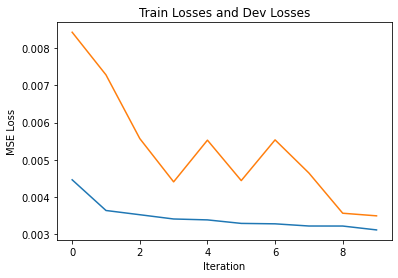

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.title('Train Losses and Dev Losses')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.plot(range(len(tls)), tls)
plt.plot(range(len(vls)), vls)
print(train_stats)

In [21]:
#evaluate on test set
test_df = pd.read_csv('../input/general-language-understanding-evaluation/STS/STS-B/test.tsv', sep='\t', engine='python', error_bad_lines=False)
test_df = train_df.dropna()
test_df.head()

Skipping line 893: '	' expected after '"'
Skipping line 900: '	' expected after '"'
Skipping line 918: '	' expected after '"'
Skipping line 919: '	' expected after '"'
Skipping line 933: '	' expected after '"'
Skipping line 941: '	' expected after '"'
Skipping line 963: '	' expected after '"'
Skipping line 983: '	' expected after '"'
Skipping line 991: '	' expected after '"'
Skipping line 997: '	' expected after '"'
Skipping line 1018: '	' expected after '"'
Skipping line 1026: '	' expected after '"'
Skipping line 1030: '	' expected after '"'
Skipping line 1051: '	' expected after '"'
Skipping line 1053: '	' expected after '"'
Skipping line 1055: '	' expected after '"'
Skipping line 1071: '	' expected after '"'
Skipping line 1072: '	' expected after '"'
Skipping line 1074: '	' expected after '"'
Skipping line 1078: '	' expected after '"'
Skipping line 1105: '	' expected after '"'
Skipping line 1111: '	' expected after '"'
Skipping line 1120: unexpected end of data


,index,genre,filename,year,old_index,source1,source2,sentence1,sentence2,score
0,0,main-captions,MSRvid,2012test,1,none,none,A plane is taking off.,An air plane is taking off.,5.00
1,1,main-captions,MSRvid,2012test,4,none,none,A man is playing a large flute.,A man is playing a flute.,3.80
2,2,main-captions,MSRvid,2012test,5,none,none,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,3,main-captions,MSRvid,2012test,6,none,none,Three men are playing chess.,Two men are playing chess.,2.60
4,4,main-captions,MSRvid,2012test,9,none,none,A man is playing the cello.,A man seated is playing the cello.,4.25


In [22]:
test_df.shape

(5703, 10)

In [23]:
def evaluate(model, criterion, dataloader, device="cuda"):
    print("Running Evaluation...")
    t0 = time.time()

    # Put model in evaluation mode to evaluate loss on the validation set
    model.to(device)
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0
    
    outputs = []

    # Evaluate data for one epoch
    for batch in dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_segment_mask, b_labels = batch
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate validation loss
            output = model(input_ids=b_input_ids, attention_mask=b_input_mask, segment_mask=b_segment_mask)
            outputs.append(output)
            # store valid loss
            loss = criterion(output, torch.reshape(b_labels, (b_labels.size()[0], 1)))
            eval_loss += loss.item()
            num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    eval_time = format_time(time.time() - t0)

    print("  Evaluation Loss: {0:.2f}".format(epoch_eval_loss))
    print("  Evaluation took: {:}".format(eval_time))
    
    o = np.array(outputs)
    o.shape

    outs = []
    for item in o:
        temp = torch.flatten(item)    
        outs.extend(temp.cpu().numpy())

    outs = np.array(outs)
    
    return (outs*5.0).tolist()

In [24]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
test_dataset = preproc_sts_b_xlnet(test_df, tokenizer)

test_dataloader = DataLoader(
            test_dataset, 
            sampler = SequentialSampler(test_dataset), 
            batch_size = 16 
        )

In [25]:
base_net,_,_,_,_ = load_model(save_path, XLNet_For_Regression)
criterion = torch.nn.MSELoss()
outputs = evaluate(base_net, criterion, test_dataloader, device="cuda")

Running Evaluation...
  Evaluation Loss: 0.00
  Evaluation took: 0:02:07


In [26]:
outputs

[4.450957298278809,
 4.301640510559082,
 4.986700534820557,
 3.70792293548584,
 4.308657169342041,
 1.985074758529663,
 1.9158337116241455,
 3.627497911453247,
 4.152839660644531,
 4.57917594909668,
 3.9103877544403076,
 4.3708953857421875,
 4.0192952156066895,
 4.47635555267334,
 3.0505733489990234,
 4.340161323547363,
 5.216917514801025,
 1.7394585609436035,
 3.577566385269165,
 3.9621729850769043,
 4.274978160858154,
 3.2534308433532715,
 4.489130020141602,
 2.956000804901123,
 3.941091537475586,
 4.706230163574219,
 4.318373203277588,
 3.882002830505371,
 5.305785179138184,
 4.464145660400391,
 4.447237968444824,
 3.5683321952819824,
 3.278048276901245,
 2.5623514652252197,
 4.447991371154785,
 3.608567714691162,
 4.326700210571289,
 3.5402379035949707,
 3.9429402351379395,
 4.255709171295166,
 3.762486219406128,
 3.997405529022217,
 3.7222070693969727,
 3.0698370933532715,
 4.685169219970703,
 3.7529592514038086,
 3.793743133544922,
 3.681612014770508,
 4.237008571624756,
 3.71051

In [27]:
test_scores = test_df['score'].tolist()

In [28]:
from scipy.stats import pearsonr
#pearson correlation between scores
pearsonr(test_scores,outputs)

(0.6951806281307585, 0.0)

In [29]:
#try again with a few different layers
XLnet_6 = XLNet_For_Regression(n_linear=6)
XLnet_9 = XLNet_For_Regression(n_linear=9)

optimizer6 = AdamW(XLnet_6.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  # eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 weight_decay=0.01,
                 correct_bias=False
                )
criterion = torch.nn.MSELoss()

xl6 = 'XLNetBase_6.pt'
torch.autograd.set_detect_anomaly(True) 
XLnet_6, tls6, vls6, train_stats =                        train(model=XLnet_6,\
                                                              num_epochs=num_epochs,\
                                                              optimizer=optimizer6,\
                                                              criterion=criterion, \
                                                              train_dataloader=train_dataloader,\
                                                              valid_dataloader=validation_dataloader,\
                                                              model_save_path=xl6,\
                                                              device="cuda"
                                                              )

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


======== Epoch 0 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:13

Running Validation...
  Validation Loss: 0.01
  Validation took: 0:00:33


Epoch:  10%|█         | 1/10 [02:46<24:58, 166.46s/it]

Saving model at epoch 0 with validation loss of 0.006219112027184407

======== Epoch 1 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:13

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:33


Epoch:  20%|██        | 2/10 [05:33<22:12, 166.57s/it]

Saving model at epoch 1 with validation loss of 0.004909440998550726

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:13

Running Validation...


Epoch:  30%|███       | 3/10 [08:18<19:24, 166.30s/it]

  Validation Loss: 0.01
  Validation took: 0:00:33

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:13

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:33


Epoch:  40%|████      | 4/10 [11:05<16:38, 166.45s/it]

Saving model at epoch 3 with validation loss of 0.0044055126890061415

======== Epoch 4 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:13

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:33


Epoch:  50%|█████     | 5/10 [13:52<13:52, 166.53s/it]

Saving model at epoch 4 with validation loss of 0.003810353382342251

======== Epoch 5 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:13

Running Validation...


Epoch:  60%|██████    | 6/10 [16:38<11:04, 166.23s/it]

  Validation Loss: 0.01
  Validation took: 0:00:33

======== Epoch 6 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:13

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:33


Epoch:  70%|███████   | 7/10 [19:24<08:19, 166.37s/it]

Saving model at epoch 6 with validation loss of 0.0037245324138686906

======== Epoch 7 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:13

Running Validation...


Epoch:  80%|████████  | 8/10 [22:10<05:32, 166.13s/it]

  Validation Loss: 0.00
  Validation took: 0:00:33

======== Epoch 8 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:13

Running Validation...


Epoch:  90%|█████████ | 9/10 [24:55<02:45, 165.96s/it]

  Validation Loss: 0.01
  Validation took: 0:00:33

======== Epoch 9 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:44.
  Batch   320  of    357.    Elapsed: 0:01:59.

  Average training loss: 0.00
  Training epcoh took: 0:02:13

Running Validation...


Epoch: 100%|██████████| 10/10 [27:41<00:00, 166.13s/it]

  Validation Loss: 0.00
  Validation took: 0:00:33

Training complete!
Total training took 0:27:41 (h:mm:ss)


[{'epoch': 0, 'Training Loss': 0.00464368489749407, 'Valid. Loss': 0.006219112027184407, 'Training Time': '0:02:13', 'Validation Time': '0:00:33'}, {'epoch': 1, 'Training Loss': 0.003699092212401418, 'Valid. Loss': 0.004909440998550726, 'Training Time': '0:02:13', 'Validation Time': '0:00:33'}, {'epoch': 2, 'Training Loss': 0.0035679645571147643, 'Valid. Loss': 0.005410585958594666, 'Training Time': '0:02:13', 'Validation Time': '0:00:33'}, {'epoch': 3, 'Training Loss': 0.0034894837690678977, 'Valid. Loss': 0.0044055126890061415, 'Training Time': '0:02:13', 'Validation Time': '0:00:33'}, {'epoch': 4, 'Training Loss': 0.0033387847208159443, 'Valid. Loss': 0.003810353382342251, 'Training Time': '0:02:13', 'Validation Time': '0:00:33'}, {'epoch': 5, 'Training Loss': 0.0033290065885734584, 'Valid. Loss': 0.006090461373232402, 'Training Time': '0:02:13', 'Validation Time': '0:00:33'}, {'epoch': 6, 'Training Loss': 0.003224743294669895, 'Valid. Loss': 0.0037245324138686906, 'Training Time': 

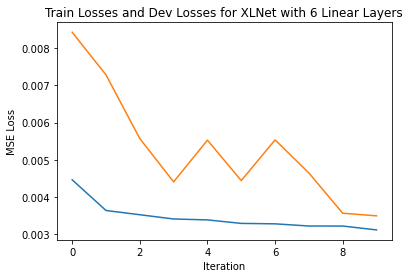

In [30]:
plt.figure()
plt.title('Train Losses and Dev Losses for XLNet with 6 Linear Layers')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.plot(range(len(tls)), tls)
plt.plot(range(len(vls)), vls)
print(train_stats)

In [31]:
net_6,_,_,_,_ = load_model(xl6, XLNet_For_Regression, {'n_linear': 6})
criterion = torch.nn.MSELoss()
outputs = evaluate(net_6, criterion, test_dataloader, device="cuda")

pearsonr(test_scores,outputs)

Running Evaluation...
  Evaluation Loss: 0.00
  Evaluation took: 0:02:07


(0.6373537037709239, 0.0)

In [32]:
outputs

[4.0988450050354,
 4.111915111541748,
 4.752392292022705,
 3.636965274810791,
 3.75378155708313,
 2.4428608417510986,
 2.031471014022827,
 3.7044601440429688,
 4.062753677368164,
 4.292354583740234,
 4.047545433044434,
 4.282285213470459,
 3.9509379863739014,
 4.368196487426758,
 3.246622323989868,
 4.2560834884643555,
 4.8034796714782715,
 1.8898546695709229,
 3.5873708724975586,
 3.958746910095215,
 4.138064861297607,
 3.4524264335632324,
 4.444390296936035,
 2.6886353492736816,
 3.897606372833252,
 4.771592617034912,
 4.0612945556640625,
 3.890085458755493,
 5.0026326179504395,
 4.266229629516602,
 4.424561977386475,
 3.6178083419799805,
 3.399348497390747,
 2.8544106483459473,
 4.206882953643799,
 3.620457410812378,
 4.172888278961182,
 3.6600635051727295,
 4.002129554748535,
 4.090258598327637,
 3.617292642593384,
 3.9383020401000977,
 3.762171745300293,
 3.1876752376556396,
 4.432997226715088,
 3.75760817527771,
 3.753676414489746,
 3.6348679065704346,
 4.086094379425049,
 3.7471

In [33]:
len(tls)

10

In [34]:

optimizer9 = AdamW(XLnet_9.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  # eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 weight_decay=0.01,
                 correct_bias=False
                )
criterion = torch.nn.MSELoss()

xl9 = 'XLNetBase_9.pt'
torch.autograd.set_detect_anomaly(True) 
XLnet_9, tls, vls, train_stats =                        train(model=XLnet_9,\
                                                              num_epochs=num_epochs,\
                                                              optimizer=optimizer9,\
                                                              criterion=criterion, \
                                                              train_dataloader=train_dataloader,\
                                                              valid_dataloader=validation_dataloader,\
                                                              model_save_path=xl9,\
                                                              device="cuda"
                                                              )

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


======== Epoch 0 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:02:00.

  Average training loss: 0.01
  Training epcoh took: 0:02:14

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:33


Epoch:  10%|█         | 1/10 [02:47<25:04, 167.11s/it]

Saving model at epoch 0 with validation loss of 0.003767098258781009

======== Epoch 1 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:02:00.

  Average training loss: 0.00
  Training epcoh took: 0:02:14

Running Validation...


Epoch:  20%|██        | 2/10 [05:33<22:15, 166.88s/it]

  Validation Loss: 0.00
  Validation took: 0:00:33

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:02:00.

  Average training loss: 0.00
  Training epcoh took: 0:02:14

Running Validation...


Epoch:  30%|███       | 3/10 [08:19<19:26, 166.71s/it]

  Validation Loss: 0.00
  Validation took: 0:00:33

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:02:00.

  Average training loss: 0.00
  Training epcoh took: 0:02:14

Running Validation...


Epoch:  40%|████      | 4/10 [11:05<16:39, 166.55s/it]

  Validation Loss: 0.00
  Validation took: 0:00:33

======== Epoch 4 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:02:00.

  Average training loss: 0.00
  Training epcoh took: 0:02:14

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:33


Epoch:  50%|█████     | 5/10 [13:53<13:53, 166.79s/it]

Saving model at epoch 4 with validation loss of 0.003242532303779604

======== Epoch 5 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:02:00.

  Average training loss: 0.00
  Training epcoh took: 0:02:14

Running Validation...


Epoch:  60%|██████    | 6/10 [16:39<11:06, 166.62s/it]

  Validation Loss: 0.00
  Validation took: 0:00:33

======== Epoch 6 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:02:00.

  Average training loss: 0.00
  Training epcoh took: 0:02:14

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:33


Epoch:  70%|███████   | 7/10 [19:27<08:20, 166.88s/it]

Saving model at epoch 6 with validation loss of 0.0030906309042016446

======== Epoch 7 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:02:00.

  Average training loss: 0.00
  Training epcoh took: 0:02:14

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:33


Epoch:  80%|████████  | 8/10 [22:14<05:34, 167.03s/it]

Saving model at epoch 7 with validation loss of 0.0029090841435104793

======== Epoch 8 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:02:00.

  Average training loss: 0.00
  Training epcoh took: 0:02:14

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:33


Epoch:  90%|█████████ | 9/10 [25:01<02:47, 167.15s/it]

Saving model at epoch 8 with validation loss of 0.0029076609737605816

======== Epoch 9 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:15.
  Batch    80  of    357.    Elapsed: 0:00:30.
  Batch   120  of    357.    Elapsed: 0:00:45.
  Batch   160  of    357.    Elapsed: 0:01:00.
  Batch   200  of    357.    Elapsed: 0:01:15.
  Batch   240  of    357.    Elapsed: 0:01:30.
  Batch   280  of    357.    Elapsed: 0:01:45.
  Batch   320  of    357.    Elapsed: 0:02:00.

  Average training loss: 0.00
  Training epcoh took: 0:02:14

Running Validation...


Epoch: 100%|██████████| 10/10 [27:47<00:00, 166.80s/it]

  Validation Loss: 0.00
  Validation took: 0:00:33

Training complete!
Total training took 0:27:48 (h:mm:ss)


[{'epoch': 0, 'Training Loss': 0.005223783110314956, 'Valid. Loss': 0.003767098258781009, 'Training Time': '0:02:14', 'Validation Time': '0:00:33'}, {'epoch': 1, 'Training Loss': 0.0038020289136420503, 'Valid. Loss': 0.004119306981629773, 'Training Time': '0:02:14', 'Validation Time': '0:00:33'}, {'epoch': 2, 'Training Loss': 0.003586984140719737, 'Valid. Loss': 0.004873593148131812, 'Training Time': '0:02:14', 'Validation Time': '0:00:33'}, {'epoch': 3, 'Training Loss': 0.003517098551739857, 'Valid. Loss': 0.004000061714890593, 'Training Time': '0:02:14', 'Validation Time': '0:00:33'}, {'epoch': 4, 'Training Loss': 0.003392733965188594, 'Valid. Loss': 0.003242532303779604, 'Training Time': '0:02:14', 'Validation Time': '0:00:33'}, {'epoch': 5, 'Training Loss': 0.003354299092032022, 'Valid. Loss': 0.0039859470960341, 'Training Time': '0:02:14', 'Validation Time': '0:00:33'}, {'epoch': 6, 'Training Loss': 0.0032721312584980274, 'Valid. Loss': 0.0030906309042016446, 'Training Time': '0:0

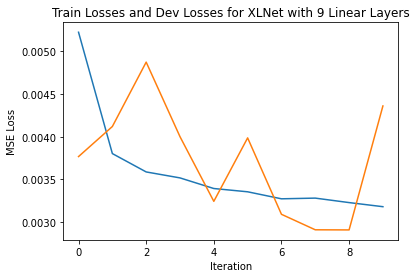

In [35]:
plt.figure()
plt.title('Train Losses and Dev Losses for XLNet with 9 Linear Layers')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.plot(range(len(tls)), tls)
plt.plot(range(len(vls)), vls)
print(train_stats)

In [36]:
net_9,_,_,_,_ = load_model(xl9, XLNet_For_Regression, {'n_linear': 9})
criterion = torch.nn.MSELoss()
outputs = evaluate(net_9, criterion, test_dataloader, device="cuda")

pearsonr(test_scores,outputs)

Running Evaluation...
  Evaluation Loss: 0.00
  Evaluation took: 0:02:07


(0.6865273453370979, 0.0)

From the above it seems clear that depth helps with model accuracy, as the pearson correlation coefficient between the predicted values and the labels increases. The increase is noticeable but not substantial between the XLNet models with 6 and 9 linear layers for regression, but this result can be improved via hyperparameter tuning.

Below let's try the same experiment but using Large XLNet

In [37]:
class Large_XLNet_For_Regression(torch.nn.Module):
    def __init__(self, n_linear=3):
        super(Large_XLNet_For_Regression, self).__init__()
        #load base model
        self.xlnet = XLNetModel.from_pretrained('xlnet-large-cased')
        
        #set up linear layers and regression output
        self.linear_layers = []
        for i in range(n_linear):
            self.linear_layers.append(torch.nn.Linear(1024,1024))
            self.linear_layers.append(torch.nn.LeakyReLU())
        self.linear_layers.append(torch.nn.Linear(1024,1))
        self.linear_layers.append(torch.nn.LeakyReLU())
        
        
        self.linear_layers = torch.nn.ModuleList(self.linear_layers)
        
    def forward(self, input_ids, attention_mask, segment_mask):
        xlnet_output = self.xlnet(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=segment_mask
        )
        
        #print(xlnet_output)
        
        output = self.pool_hidden_state(xlnet_output)
        
        #print(output)
        
        for layer in self.linear_layers:
            output = layer(output)
            
        #print(output)
        
        return output
    
    #copied from: https://www.kaggle.com/jaskaransingh/xlnet-fine-tuning-with-pytorch
    def pool_hidden_state(self, last_hidden_state):
        """
        Pool the output vectors into a single mean vector 
        """
        last_hidden_state = last_hidden_state[0]
        mean_last_hidden_state = torch.mean(last_hidden_state, 1)
        return mean_last_hidden_state
        
    def freeze_xlnet_decoder(self):
        """
        Freeze XLNet weight parameters. They will not be updated during training.
        """
        for param in self.xlnet.parameters():
            param.requires_grad = False
            
    def train(self, mode=True):
        if mode:
            self.freeze_xlnet_decoder()
        super().train(mode)

In [38]:
#create dataloaders
#we must reprocess because XLNet Large has its own tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased', do_lower_case=True)

large_train_dataset = preproc_sts_b_xlnet(train_df, tokenizer)

large_train_dataloader = DataLoader(
            large_train_dataset, 
            sampler = RandomSampler(large_train_dataset), 
            batch_size = 16 
        )

large_validation_dataset = preproc_sts_b_xlnet(dev_df, tokenizer)

large_validation_dataloader = DataLoader(
            large_validation_dataset, 
            sampler = SequentialSampler(large_validation_dataset), 
            batch_size = 16 
        )

large_test_dataset = preproc_sts_b_xlnet(test_df, tokenizer)

large_test_dataloader = DataLoader(
            large_test_dataset, 
            sampler = SequentialSampler(large_test_dataset), 
            batch_size = 16 
        )

In [39]:
#train, evaluate models
num_epochs = 10
large_base_net = Large_XLNet_For_Regression()


lb_optimizer = AdamW(large_base_net.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  # eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 weight_decay=0.01,
                 correct_bias=False
                )
criterion = torch.nn.MSELoss()

large_xl = 'LargeXLNetBase.pt'
torch.autograd.set_detect_anomaly(True) 
large_base_net, tls, vls, train_stats =                        train(model=large_base_net,\
                                                              num_epochs=num_epochs,\
                                                              optimizer=lb_optimizer,\
                                                              criterion=criterion, \
                                                              train_dataloader=large_train_dataloader,\
                                                              valid_dataloader=large_validation_dataloader,\
                                                              model_save_path=large_xl,\
                                                              device="cuda"
                                                              )

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


======== Epoch 0 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:46.
  Batch   320  of    357.    Elapsed: 0:05:27.

  Average training loss: 0.01
  Training epcoh took: 0:06:05

Running Validation...
  Validation Loss: 0.01
  Validation took: 0:01:31


Epoch:  10%|█         | 1/10 [07:39<1:08:51, 459.02s/it]

Saving model at epoch 0 with validation loss of 0.005735141137310559

======== Epoch 1 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:27.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:01:31


Epoch:  20%|██        | 2/10 [15:18<1:01:12, 459.04s/it]

Saving model at epoch 1 with validation loss of 0.0042448923907160594

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:46.
  Batch   320  of    357.    Elapsed: 0:05:27.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...


Epoch:  30%|███       | 3/10 [22:53<53:25, 457.93s/it]  

  Validation Loss: 0.00
  Validation took: 0:01:31

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:46.
  Batch   320  of    357.    Elapsed: 0:05:27.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:01:31


Epoch:  40%|████      | 4/10 [30:32<45:49, 458.25s/it]

Saving model at epoch 3 with validation loss of 0.0036554471382735042

======== Epoch 4 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:46.
  Batch   320  of    357.    Elapsed: 0:05:27.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...


Epoch:  50%|█████     | 5/10 [38:07<38:06, 457.39s/it]

  Validation Loss: 0.00
  Validation took: 0:01:31

======== Epoch 5 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:27.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...


Epoch:  60%|██████    | 6/10 [45:43<30:27, 456.81s/it]

  Validation Loss: 0.00
  Validation took: 0:01:31

======== Epoch 6 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:28.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:01:31


Epoch:  70%|███████   | 7/10 [53:22<22:52, 457.54s/it]

Saving model at epoch 6 with validation loss of 0.0034873312312450134

======== Epoch 7 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:27.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...


Epoch:  80%|████████  | 8/10 [1:00:58<15:13, 456.93s/it]

  Validation Loss: 0.00
  Validation took: 0:01:31

======== Epoch 8 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:27.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...


Epoch:  90%|█████████ | 9/10 [1:08:33<07:36, 456.49s/it]

  Validation Loss: 0.00
  Validation took: 0:01:31

======== Epoch 9 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:27.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...


Epoch: 100%|██████████| 10/10 [1:16:08<00:00, 456.90s/it]

  Validation Loss: 0.00
  Validation took: 0:01:31

Training complete!
Total training took 1:16:09 (h:mm:ss)


[{'epoch': 0, 'Training Loss': 0.005128378672686958, 'Valid. Loss': 0.005735141137310559, 'Training Time': '0:06:05', 'Validation Time': '0:01:31'}, {'epoch': 1, 'Training Loss': 0.00445700385912341, 'Valid. Loss': 0.0042448923907160594, 'Training Time': '0:06:05', 'Validation Time': '0:01:31'}, {'epoch': 2, 'Training Loss': 0.004248886447391363, 'Valid. Loss': 0.004580451046980495, 'Training Time': '0:06:05', 'Validation Time': '0:01:31'}, {'epoch': 3, 'Training Loss': 0.004193650459302071, 'Valid. Loss': 0.0036554471382735042, 'Training Time': '0:06:05', 'Validation Time': '0:01:31'}, {'epoch': 4, 'Training Loss': 0.004056981452986501, 'Valid. Loss': 0.004333922953961731, 'Training Time': '0:06:05', 'Validation Time': '0:01:31'}, {'epoch': 5, 'Training Loss': 0.003994888662129207, 'Valid. Loss': 0.003815963598870897, 'Training Time': '0:06:05', 'Validation Time': '0:01:31'}, {'epoch': 6, 'Training Loss': 0.003910832616902121, 'Valid. Loss': 0.0034873312312450134, 'Training Time': '0:

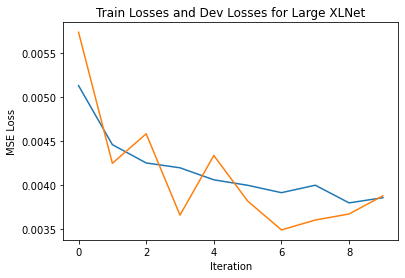

In [40]:
plt.figure()
plt.title('Train Losses and Dev Losses for Large XLNet')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.plot(range(len(tls)), tls)
plt.plot(range(len(vls)), vls)
print(train_stats)

In [41]:
large_base_net,_,_,_,_ = load_model(large_xl, Large_XLNet_For_Regression)
criterion = torch.nn.MSELoss()
outputs = evaluate(large_base_net, criterion, large_test_dataloader, device="cuda")


pearsonr(test_scores,outputs)

Running Evaluation...
  Evaluation Loss: 0.00
  Evaluation took: 0:05:54


(0.624569147162096, 0.0)

In [42]:
large_6lin = Large_XLNet_For_Regression(n_linear=6)


lb6_optimizer = AdamW(large_6lin.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  # eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 weight_decay=0.01,
                 correct_bias=False
                )
criterion = torch.nn.MSELoss()

large_xl6 = 'LargeXLNetBase_6.pt'
torch.autograd.set_detect_anomaly(True) 
large_6lin, tls, vls, train_stats =                        train(model=large_6lin,\
                                                              num_epochs=num_epochs,\
                                                              optimizer=lb6_optimizer,\
                                                              criterion=criterion, \
                                                              train_dataloader=large_train_dataloader,\
                                                              valid_dataloader=large_validation_dataloader,\
                                                              model_save_path=large_xl6,\
                                                              device="cuda"
                                                              )

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


======== Epoch 0 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:28.

  Average training loss: 0.01
  Training epcoh took: 0:06:05

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:01:31


Epoch:  10%|█         | 1/10 [07:39<1:08:57, 459.69s/it]

Saving model at epoch 0 with validation loss of 0.004798439372730679

======== Epoch 1 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:28.

  Average training loss: 0.00
  Training epcoh took: 0:06:06

Running Validation...


Epoch:  20%|██        | 2/10 [15:15<1:01:09, 458.65s/it]

  Validation Loss: 0.01
  Validation took: 0:01:31

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:28.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...


Epoch:  30%|███       | 3/10 [22:51<53:25, 457.88s/it]  

  Validation Loss: 0.01
  Validation took: 0:01:31

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:28.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...


Epoch:  40%|████      | 4/10 [30:28<45:44, 457.34s/it]

  Validation Loss: 0.01
  Validation took: 0:01:31

======== Epoch 4 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:28.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...


Epoch:  50%|█████     | 5/10 [38:04<38:04, 456.93s/it]

  Validation Loss: 0.01
  Validation took: 0:01:31

======== Epoch 5 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:28.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:01:31


Epoch:  60%|██████    | 6/10 [45:43<30:31, 457.82s/it]

Saving model at epoch 5 with validation loss of 0.004364210266877101

======== Epoch 6 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:28.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:01:31


Epoch:  70%|███████   | 7/10 [53:23<22:55, 458.41s/it]

Saving model at epoch 6 with validation loss of 0.00422943112525073

======== Epoch 7 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:28.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:01:31


Epoch:  80%|████████  | 8/10 [1:01:03<15:17, 458.79s/it]

Saving model at epoch 7 with validation loss of 0.004067535797975606

======== Epoch 8 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:28.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:01:31


Epoch:  90%|█████████ | 9/10 [1:08:42<07:39, 459.03s/it]

Saving model at epoch 8 with validation loss of 0.003669717182326993

======== Epoch 9 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:41.
  Batch    80  of    357.    Elapsed: 0:01:22.
  Batch   120  of    357.    Elapsed: 0:02:03.
  Batch   160  of    357.    Elapsed: 0:02:44.
  Batch   200  of    357.    Elapsed: 0:03:25.
  Batch   240  of    357.    Elapsed: 0:04:06.
  Batch   280  of    357.    Elapsed: 0:04:47.
  Batch   320  of    357.    Elapsed: 0:05:28.

  Average training loss: 0.00
  Training epcoh took: 0:06:05

Running Validation...


Epoch: 100%|██████████| 10/10 [1:16:18<00:00, 457.90s/it]

  Validation Loss: 0.00
  Validation took: 0:01:31

Training complete!
Total training took 1:16:19 (h:mm:ss)


[{'epoch': 0, 'Training Loss': 0.005313450287666297, 'Valid. Loss': 0.004798439372730679, 'Training Time': '0:06:05', 'Validation Time': '0:01:31'}, {'epoch': 1, 'Training Loss': 0.004401137689482888, 'Valid. Loss': 0.005359442336758521, 'Training Time': '0:06:06', 'Validation Time': '0:01:31'}, {'epoch': 2, 'Training Loss': 0.0042492347074907415, 'Valid. Loss': 0.005363021704151218, 'Training Time': '0:06:05', 'Validation Time': '0:01:31'}, {'epoch': 3, 'Training Loss': 0.0041092859877346274, 'Valid. Loss': 0.005521341076124554, 'Training Time': '0:06:05', 'Validation Time': '0:01:31'}, {'epoch': 4, 'Training Loss': 0.004059426616482122, 'Valid. Loss': 0.005034783144652721, 'Training Time': '0:06:05', 'Validation Time': '0:01:31'}, {'epoch': 5, 'Training Loss': 0.004033806726438381, 'Valid. Loss': 0.004364210266877101, 'Training Time': '0:06:05', 'Validation Time': '0:01:31'}, {'epoch': 6, 'Training Loss': 0.003954845992252217, 'Valid. Loss': 0.00422943112525073, 'Training Time': '0:0

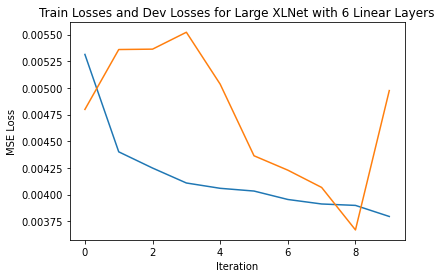

In [43]:
plt.figure()
plt.title('Train Losses and Dev Losses for Large XLNet with 6 Linear Layers')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.plot(range(len(tls)), tls)
plt.plot(range(len(vls)), vls)
print(train_stats)

In [44]:
large_6lin,_,_,_,_ = load_model(large_xl6, Large_XLNet_For_Regression, {'n_linear': 6})
criterion = torch.nn.MSELoss()
outputs = evaluate(large_6lin, criterion, large_test_dataloader, device="cuda")


pearsonr(test_scores,outputs)

Running Evaluation...
  Evaluation Loss: 0.00
  Evaluation took: 0:05:54


(0.6372633198984137, 0.0)

In [45]:
large_9lin = Large_XLNet_For_Regression(n_linear=9)


lb9_optimizer = AdamW(large_9lin.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  # eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 weight_decay=0.01,
                 correct_bias=False
                )
criterion = torch.nn.MSELoss()

large_xl9 = 'LargeXLNetBase_9.pt'
torch.autograd.set_detect_anomaly(True) 
large_9lin, tls, vls, train_stats =                        train(model=large_9lin,\
                                                              num_epochs=num_epochs,\
                                                              optimizer=lb9_optimizer,\
                                                              criterion=criterion, \
                                                              train_dataloader=large_train_dataloader,\
                                                              valid_dataloader=large_validation_dataloader,\
                                                              model_save_path=large_xl9,\
                                                              device="cuda"
                                                              )

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


======== Epoch 0 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:42.
  Batch    80  of    357.    Elapsed: 0:01:24.
  Batch   120  of    357.    Elapsed: 0:02:05.
  Batch   160  of    357.    Elapsed: 0:02:47.
  Batch   200  of    357.    Elapsed: 0:03:29.
  Batch   240  of    357.    Elapsed: 0:04:11.
  Batch   280  of    357.    Elapsed: 0:04:52.
  Batch   320  of    357.    Elapsed: 0:05:34.

  Average training loss: 0.01
  Training epcoh took: 0:06:12

Running Validation...
  Validation Loss: 0.01
  Validation took: 0:01:32


Epoch:  10%|█         | 1/10 [07:48<1:10:15, 468.37s/it]

Saving model at epoch 0 with validation loss of 0.005728179390299671

======== Epoch 1 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:42.
  Batch    80  of    357.    Elapsed: 0:01:24.
  Batch   120  of    357.    Elapsed: 0:02:05.
  Batch   160  of    357.    Elapsed: 0:02:47.
  Batch   200  of    357.    Elapsed: 0:03:29.
  Batch   240  of    357.    Elapsed: 0:04:10.
  Batch   280  of    357.    Elapsed: 0:04:52.
  Batch   320  of    357.    Elapsed: 0:05:34.

  Average training loss: 0.00
  Training epcoh took: 0:06:12

Running Validation...


Epoch:  20%|██        | 2/10 [15:32<1:02:17, 467.15s/it]

  Validation Loss: 0.01
  Validation took: 0:01:32

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:42.
  Batch    80  of    357.    Elapsed: 0:01:23.
  Batch   120  of    357.    Elapsed: 0:02:05.
  Batch   160  of    357.    Elapsed: 0:02:47.
  Batch   200  of    357.    Elapsed: 0:03:29.
  Batch   240  of    357.    Elapsed: 0:04:10.
  Batch   280  of    357.    Elapsed: 0:04:52.
  Batch   320  of    357.    Elapsed: 0:05:34.

  Average training loss: 0.00
  Training epcoh took: 0:06:12

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:01:32


Epoch:  30%|███       | 3/10 [23:20<54:31, 467.38s/it]  

Saving model at epoch 2 with validation loss of 0.004860180060258893

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:42.
  Batch    80  of    357.    Elapsed: 0:01:24.
  Batch   120  of    357.    Elapsed: 0:02:05.
  Batch   160  of    357.    Elapsed: 0:02:47.
  Batch   200  of    357.    Elapsed: 0:03:29.
  Batch   240  of    357.    Elapsed: 0:04:11.
  Batch   280  of    357.    Elapsed: 0:04:52.
  Batch   320  of    357.    Elapsed: 0:05:34.

  Average training loss: 0.00
  Training epcoh took: 0:06:12

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:01:32


Epoch:  40%|████      | 4/10 [31:08<46:45, 467.62s/it]

Saving model at epoch 3 with validation loss of 0.004647641595496311

======== Epoch 4 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:42.
  Batch    80  of    357.    Elapsed: 0:01:24.
  Batch   120  of    357.    Elapsed: 0:02:05.
  Batch   160  of    357.    Elapsed: 0:02:47.
  Batch   200  of    357.    Elapsed: 0:03:29.
  Batch   240  of    357.    Elapsed: 0:04:11.
  Batch   280  of    357.    Elapsed: 0:04:52.
  Batch   320  of    357.    Elapsed: 0:05:34.

  Average training loss: 0.00
  Training epcoh took: 0:06:12

Running Validation...


Epoch:  50%|█████     | 5/10 [38:53<38:53, 466.65s/it]

  Validation Loss: 0.01
  Validation took: 0:01:32

======== Epoch 5 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:42.
  Batch    80  of    357.    Elapsed: 0:01:24.
  Batch   120  of    357.    Elapsed: 0:02:05.
  Batch   160  of    357.    Elapsed: 0:02:47.
  Batch   200  of    357.    Elapsed: 0:03:29.
  Batch   240  of    357.    Elapsed: 0:04:11.
  Batch   280  of    357.    Elapsed: 0:04:52.
  Batch   320  of    357.    Elapsed: 0:05:34.

  Average training loss: 0.00
  Training epcoh took: 0:06:12

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:01:32


Epoch:  60%|██████    | 6/10 [46:41<31:08, 467.13s/it]

Saving model at epoch 5 with validation loss of 0.0035389858608020144

======== Epoch 6 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:42.
  Batch    80  of    357.    Elapsed: 0:01:24.
  Batch   120  of    357.    Elapsed: 0:02:05.
  Batch   160  of    357.    Elapsed: 0:02:47.
  Batch   200  of    357.    Elapsed: 0:03:29.
  Batch   240  of    357.    Elapsed: 0:04:11.
  Batch   280  of    357.    Elapsed: 0:04:52.
  Batch   320  of    357.    Elapsed: 0:05:34.

  Average training loss: 0.00
  Training epcoh took: 0:06:12

Running Validation...


Epoch:  70%|███████   | 7/10 [54:25<23:18, 466.30s/it]

  Validation Loss: 0.00
  Validation took: 0:01:32

======== Epoch 7 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:42.
  Batch    80  of    357.    Elapsed: 0:01:24.
  Batch   120  of    357.    Elapsed: 0:02:05.
  Batch   160  of    357.    Elapsed: 0:02:47.
  Batch   200  of    357.    Elapsed: 0:03:29.
  Batch   240  of    357.    Elapsed: 0:04:11.
  Batch   280  of    357.    Elapsed: 0:04:52.
  Batch   320  of    357.    Elapsed: 0:05:34.

  Average training loss: 0.00
  Training epcoh took: 0:06:12

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:01:32


Epoch:  80%|████████  | 8/10 [1:02:14<15:33, 466.90s/it]

Saving model at epoch 7 with validation loss of 0.0032244213447433093

======== Epoch 8 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:42.
  Batch    80  of    357.    Elapsed: 0:01:24.
  Batch   120  of    357.    Elapsed: 0:02:05.
  Batch   160  of    357.    Elapsed: 0:02:47.
  Batch   200  of    357.    Elapsed: 0:03:29.
  Batch   240  of    357.    Elapsed: 0:04:11.
  Batch   280  of    357.    Elapsed: 0:04:52.
  Batch   320  of    357.    Elapsed: 0:05:34.

  Average training loss: 0.00
  Training epcoh took: 0:06:12

Running Validation...


Epoch:  90%|█████████ | 9/10 [1:09:58<07:46, 466.12s/it]

  Validation Loss: 0.00
  Validation took: 0:01:32

======== Epoch 9 / 10 ========
Training...
  Batch    40  of    357.    Elapsed: 0:00:42.
  Batch    80  of    357.    Elapsed: 0:01:23.
  Batch   120  of    357.    Elapsed: 0:02:05.
  Batch   160  of    357.    Elapsed: 0:02:47.
  Batch   200  of    357.    Elapsed: 0:03:29.
  Batch   240  of    357.    Elapsed: 0:04:10.
  Batch   280  of    357.    Elapsed: 0:04:52.
  Batch   320  of    357.    Elapsed: 0:05:34.

  Average training loss: 0.00
  Training epcoh took: 0:06:12

Running Validation...


Epoch: 100%|██████████| 10/10 [1:17:42<00:00, 466.25s/it]

  Validation Loss: 0.00
  Validation took: 0:01:32

Training complete!
Total training took 1:17:43 (h:mm:ss)


[{'epoch': 0, 'Training Loss': 0.005948100799497712, 'Valid. Loss': 0.005728179390299671, 'Training Time': '0:06:12', 'Validation Time': '0:01:32'}, {'epoch': 1, 'Training Loss': 0.004453236749942796, 'Valid. Loss': 0.005836684690942441, 'Training Time': '0:06:12', 'Validation Time': '0:01:32'}, {'epoch': 2, 'Training Loss': 0.004191671642970457, 'Valid. Loss': 0.004860180060258893, 'Training Time': '0:06:12', 'Validation Time': '0:01:32'}, {'epoch': 3, 'Training Loss': 0.004095450671745375, 'Valid. Loss': 0.004647641595496311, 'Training Time': '0:06:12', 'Validation Time': '0:01:32'}, {'epoch': 4, 'Training Loss': 0.00393099050531884, 'Valid. Loss': 0.005113320858029983, 'Training Time': '0:06:12', 'Validation Time': '0:01:32'}, {'epoch': 5, 'Training Loss': 0.004008635378852761, 'Valid. Loss': 0.0035389858608020144, 'Training Time': '0:06:12', 'Validation Time': '0:01:32'}, {'epoch': 6, 'Training Loss': 0.003953702668456076, 'Valid. Loss': 0.0036778790953932603, 'Training Time': '0:0

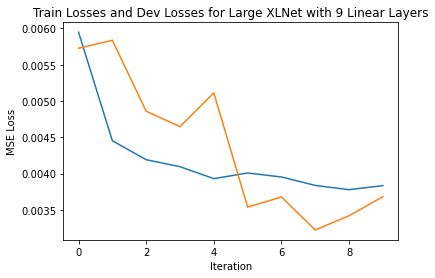

In [46]:
plt.figure()
plt.title('Train Losses and Dev Losses for Large XLNet with 9 Linear Layers')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.plot(range(len(tls)), tls)
plt.plot(range(len(vls)), vls)
print(train_stats)

In [47]:
large_9lin,_,_,_,_ = load_model(large_xl9, Large_XLNet_For_Regression, {'n_linear': 9})
criterion = torch.nn.MSELoss()
outputs = evaluate(large_9lin, criterion, large_test_dataloader, device="cuda")


pearsonr(test_scores,outputs)

Running Evaluation...
  Evaluation Loss: 0.00
  Evaluation took: 0:06:00


(0.6455378888189898, 0.0)